# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Feature Engineering](#Feature-Engineering)
- [Feature Selection](#Feature-Selection)
    - [Mathews Correlation](#Mathews-correlation)
    - [variance Inflation Factor checking](#variance-Inflation-Factor-checking)
    - [Condition number](#Condition-number)
- [Pipeline Building](#Pipeline-Building)
- [Modeling](#Modeling)
- [Model Evaluation](#Model-evaluation)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction
### Binary Classification: Day 3 - Feature Engineering
- This notebook focuses on data preparation techniques like feature engineering to improve model performance.

## Importing Libraries

In [44]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.basic_cleaning import *
from functions.pipeline_helpers import *

In [45]:
train_data = pl.read_csv("train_data.csv").pipe(reduce_memory_usage)
test_data = pl.read_csv("test_data.csv").pipe(reduce_memory_usage)
train_data.shape,test_data.shape

((5611, 19), (1406, 19))

In [46]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

## Feature Engineering

* **Streamer:** This feature combines `StreamingMovies` and `StreamingTV` into a single feature indicating whether a customer subscribes to any streaming service.
* **Safer:** This feature combines `OnlineSecurity`, `DeviceProtection`, and `OnlineBackup` into a single feature indicating a customer's preference for online security services.
* **Family:** This feature combines `Partner` and `Dependents` into a single feature indicating the presence of a family unit within a customer's household.
* **OnlinePayment:** This feature combines `PaperlessBilling` and `ElectricCheck` into a single feature indicating a customer's preference for online payment methods.
* **All:** This feature combines `Streamer`, `Safer`, and `Family` to create a group representing customers who potentially use all three service categories (streaming, security, and family plans).

We believe these new features can better capture customer preferences and potentially improve model performance.if not we can drop them


In [47]:
# replacing yes 1 and No 0
for col in cat_cols[:-1]:
    train_data=train_data.with_columns(train_data[col].str.replace_many(["Yes","No"],["1","0"]).cast(pl.Int8))
    test_data=test_data.with_columns(test_data[col].str.replace_many(["Yes","No"],["1","0"]).cast(pl.Int8))
train_data=train_data.with_columns(train_data["PaymentMethod"].is_in(["Electronic check"]).cast(pl.Int8).alias("ElectricCheck")).drop("PaymentMethod")
test_data=test_data.with_columns(test_data["PaymentMethod"].is_in(["Electronic check"]).cast(pl.Int8).alias("ElectricCheck")).drop("PaymentMethod")

In [48]:
train_data=train_data.with_columns(pl.Series((train_data["StreamingMovies"] | train_data["StreamingTV"])).alias("Streamer")).drop("StreamingMovies","StreamingTV")
train_data=train_data.with_columns(pl.Series(train_data["OnlineSecurity"] | train_data["DeviceProtection"] | train_data['OnlineBackup']).alias("Safer"))#.drop("OnlineSecurity","DeviceProtection","OnlineBackup")
train_data=train_data.with_columns(pl.Series(train_data['Partner'] | train_data['Dependents']).alias("Family")).drop("Partner","Dependents")
train_data=train_data.with_columns(pl.Series(train_data['PaperlessBilling'] & train_data["ElectricCheck"]).alias("OnlinePayment")).drop("PaperlessBilling","ElectricCheck")
train_data=train_data.with_columns(pl.Series(train_data["Streamer"] & train_data["Safer"] & train_data['Family']).alias("All"))


test_data=test_data.with_columns(pl.Series((test_data["StreamingMovies"] | test_data["StreamingTV"])).alias("Streamer")).drop("StreamingMovies","StreamingTV")
test_data=test_data.with_columns(pl.Series(test_data["OnlineSecurity"] | test_data["DeviceProtection"] | test_data['OnlineBackup']).alias("Safer"))#.drop("OnlineSecurity","DeviceProtection","OnlineBackup")
test_data=test_data.with_columns(pl.Series(test_data['Partner'] | test_data['Dependents']).alias("Family")).drop("Partner","Dependents")
test_data=test_data.with_columns(pl.Series(test_data['PaperlessBilling'] & test_data["ElectricCheck"]).alias("OnlinePayment")).drop("PaperlessBilling","ElectricCheck")
test_data=test_data.with_columns(pl.Series(test_data["Streamer"] & test_data["Safer"] & test_data['Family']).alias("All"))

In [ ]:
train_data.write_csv("../Day4_ClassBalancing/train_featureEngineered.csv")
test_data.write_csv("../Day4_ClassBalancing/test_featureEngineered.csv")
train_data.write_csv("../Day7_AutoMl/train_featureEngineered.csv")
test_data.write_csv("../Day7_AutoMl/test_featureEngineered.csv")

In [49]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

Non Binary Features

In [50]:
non_binary_cols=[col for col in num_cols if len(train_data[col].unique())>2]
binary_cols=[col for col in num_cols if len(train_data[col].unique())==2]
non_binary_cols

['tenure', 'InternetService', 'Contract', 'MonthlyCharges', 'TotalCharges']

## Feature Selection

### Mathews-correlation

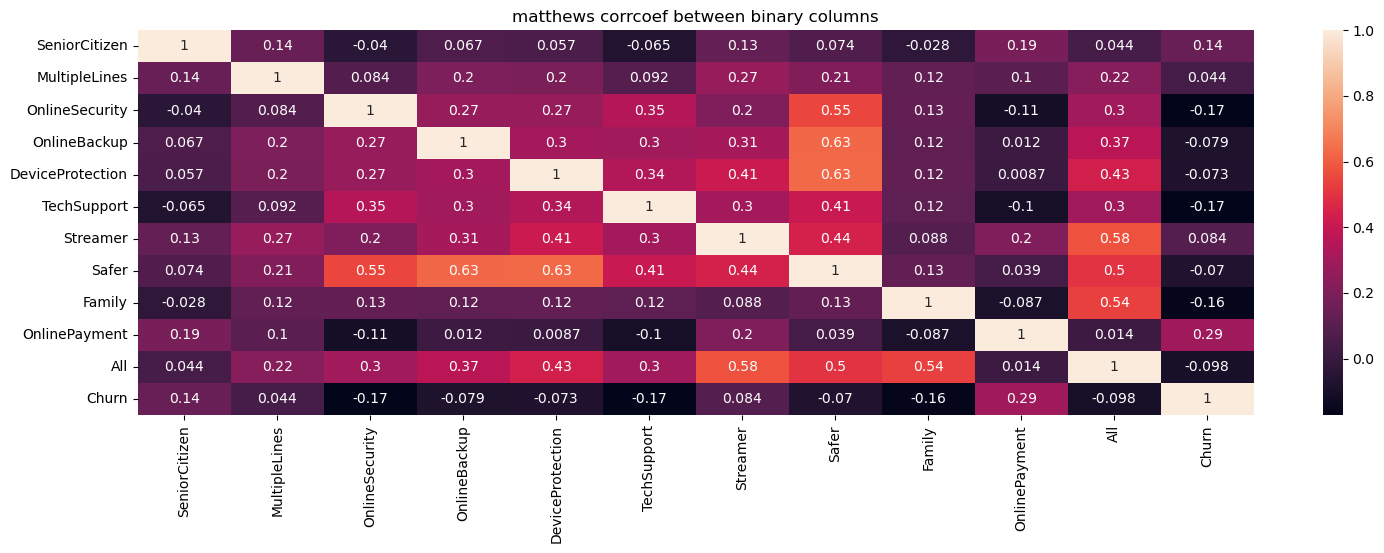

In [52]:
plot_binarycols_heatmap(train_data,binary_cols+["Churn"])

In [58]:
train_data=train_data.drop("MultipleLines","OnlineBackup","DeviceProtection")
test_data=test_data.drop("MultipleLines","OnlineBackup","DeviceProtection")

### Variance Inflation Factor checking

In [59]:
calculate_vif(train_data,"Churn",head=8)

,variables,VIF
0,const,114.089473
7,MonthlyCharges,18.788122
8,TotalCharges,10.925870
3,InternetService,10.364330
2,tenure,7.460368
9,Streamer,2.919687
13,All,2.850515
6,Contract,2.412211


### Condition Number

In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)
print(f"Condition Number : {np.linalg.cond(transformer.fit_transform(X_train))}")

Condition Number : 12.143465042114258


In [61]:
train_data.sample(5)

customerID,SeniorCitizen,tenure,InternetService,OnlineSecurity,TechSupport,Contract,MonthlyCharges,TotalCharges,Churn,Streamer,Safer,Family,OnlinePayment,All
str,i8,i8,i8,i8,i8,i8,f32,f32,i8,i8,i8,i8,i8,i8
"""8249-THVEC""",0,51,2,0,0,12,19.4,997.75,0,0,0,1,0,0
"""7296-PIXQY""",0,14,0,0,0,1,70.199997,1046.5,0,0,0,1,0,0
"""4661-NJEUX""",0,1,2,0,0,1,20.049999,20.049999,0,0,0,0,0,0
"""1573-LGXBA""",0,57,0,0,0,12,97.550003,5598.0,0,1,1,1,0,1
"""9498-FIMXL""",0,8,2,0,0,12,19.200001,161.949997,0,0,0,0,0,0


In [62]:
ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
ratio

0.2648369274639102

## Pipeline Building

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest

pipe = Pipeline(
    [
        ("tranformer", transformer),
        ('select',SelectKBest(k=10)),
        ("classifier", LogisticRegression(class_weight={0:1,1:ratio*10})),
    ]
)
pipe

Pipeline(steps=[('tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'TechSupport', 'Contract',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'Streamer',
                                                   'Safer', 'Family',
                                                   'OnlinePayment', 'All'])])),
                ('select', SelectKBest()),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 2.648369274639102}))])

## Modeling

In [70]:
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42)
pipe.fit(X_train,y_train)
cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')

Mean Train roc auc Score: 0.8419460048713083
Mean Train recall Score: 0.789364210554927

Mean Test roc auc Score: 0.8400557724524489
Mean Test recall Score: 0.786211578147062


## Model Evaluation

Recall score: 0.83
Correlation : 0.5013882621847326
Classification Report 
               precision    recall  f1-score   support

           0       0.92      0.73      0.82      1031
           1       0.53      0.83      0.65       375

    accuracy                           0.76      1406
   macro avg       0.72      0.78      0.73      1406
weighted avg       0.82      0.76      0.77      1406



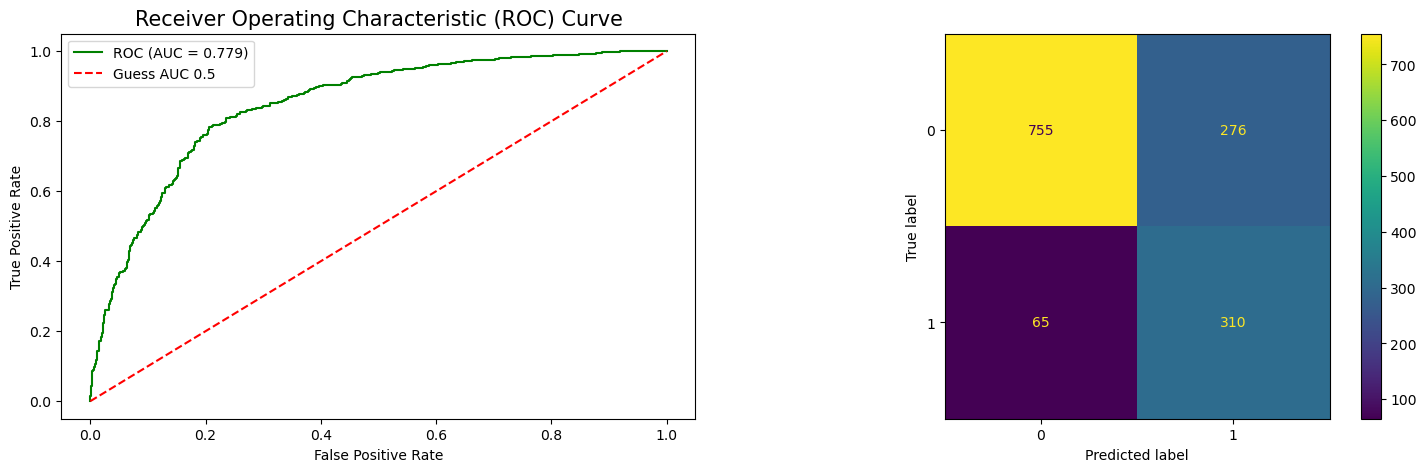

In [71]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score,recall_score
from sklearn.model_selection import cross_val_predict
# Evaluation
predictions_prob= cross_val_predict(pipe,X_test,y_test,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n",classification_report(y_test,predictions))
fpr, tpr, thresholds=roc_curve(y_test,predictions_prob[:,1])
plot_evaluation(fpr, tpr,y_test,predictions,roc_auc)

## Results
### Model Performance Summary (Day 3 - Feature Engineering for Churn Prediction)

#### Cross-Validation Results

* **Mean Train ROC AUC Score**: 0.8419
* **Mean Train Recall Score**: 0.7894

* **Mean Test ROC AUC Score**: 0.8401
* **Mean Test Recall Score**: 0.7862

#### Holdout Set Performance

* **Recall Score on Holdout Set**: 0.83

#### Correlation

* **Correlation**: 0.5014

#### Classification Report on Holdout Set

|               | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| **Class 0**   | 0.92      | 0.73   | 0.82     | 1031    |
| **Class 1**   | 0.53      | 0.83   | 0.65     | 375     |
| **Accuracy**  |           | 0.76   |          | 1406    |
| **Macro Avg** | 0.72      | 0.78   | 0.73     | 1406    |
| **Weighted Avg** | 0.82   | 0.76   | 0.77     | 1406    |

#### Insights

* **Further Recall Improvement**: After feature engineering, the model's recall score has continued to improve. The mean train recall score increased from 0.7786 (Day 2) to 0.7894, and the mean test recall score improved from 0.7767 to 0.7862. The holdout set recall score also increased from 0.81 to 0.83, demonstrating the positive impact of feature engineering on identifying churn cases.

* **Consistency**: The ROC AUC scores for both train and test sets remain consistent with previous days, indicating that the model maintains a good balance between sensitivity and specificity.

* **Precision vs. Recall Trade-off**: The precision for class 1 (churn) is similar to Day 2 at 0.53, while the recall has significantly increased to 0.83. This trade-off suggests the model has become even more adept at capturing true positives (churn cases), albeit with more false positives, which is often acceptable in churn prediction scenarios.

* **Overall Accuracy**: The overall accuracy remains stable at 0.76, reflecting the model's strong performance in distinguishing between churn and non-churn cases.

* **Correlation**: The correlation between predicted probabilities and actual class labels has slightly improved to 0.5014, indicating a stronger relationship and more reliable predictions.

#### Improvements from Previous Days

* **Recall Enhancement**: The major improvement continues to be in recall, both on cross-validation and the holdout set. This is crucial for churn prediction, as capturing more churners can lead to more effective retention strategies.
* **Model Robustness**: The consistent ROC AUC scores and the improved recall across different datasets suggest that feature engineering has further stabilized and enhanced the model.
* **Handling Class Imbalance**: Despite the class imbalance, the model effectively captures the majority of churn cases, as reflected in the improved recall scores.

#### Recommendations for Further Improvement

* **Precision Enhancement**: While the recall has improved, precision remains low. Exploring ensemble methods, further feature selection, or additional hyperparameter tuning could help improve precision.
* **Feature Engineering**: Continue to refine and add more features that could capture the nuances of churn behavior, potentially improving both recall and precision.
* **Class Imbalance Handling**: Further techniques like balanced class weights or advanced resampling methods (e.g., SMOTE) can be explored to address the remaining class imbalance.

By focusing on these aspects, the model can continue to improve, providing even more reliable predictions for churn.

## Conclusion
- 83% of churners are identified with 53% precision (chance that our predicted churners are actually churners). Indicating more than half of our predicted churners are actual Churners